# Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ladi-vton

/content/drive/MyDrive/ladi-vton


# Installing

In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 opencv-python==4.7.0.72 diffusers==0.14.0 transformers==4.27.3 accelerate==0.18.0 clean-fid==0.1.35 torchmetrics[image]==0.11.4 wandb==0.14.0 matplotlib==3.7.1 tqdm xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0

*This Result needs to be TRUE*

In [ ]:
import torch
torch.cuda.is_available()

True

# Preprocess

In [ ]:
#Clear
import os
import glob
import shutil
from PIL import Image

files = glob.glob('input/*/*/*.*')
for f in files:
  os.remove(f)

files = glob.glob('results/*/*/*.*')
for f in files:
  os.remove(f)

## Load Humans and Text pairs

In [ ]:
def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)

    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

In [ ]:
#Add pairs
def write_row(file_, *columns):
    print(*columns, sep='\t', end='\n', file=file_)

upper = open('input/upper_body/test_pairs_unpaired.txt', 'w')
lower = open('input/lower_body/test_pairs_unpaired.txt', 'w')
dresses = open('input/dresses/test_pairs_unpaired.txt', 'w')
all = open('input/test_pairs_paired.txt', 'w')

with open('images/test_pairs.txt', "r") as file:
    data = file.readlines()
    for line in data:
        word = line.split()
        org_path = 'images/humans/' + word[0]
        if(word[2] == '0'):
          write_row(upper,'0'+word[0],word[1])
          write_row(all,'0'+word[0],word[1],word[2])
          res_path = 'input/upper_body/images/0' + word[0]
        elif(word[2] == '1'):
          write_row(lower,'1'+word[0],word[1])
          write_row(all,'1'+word[0],word[1],word[2])
          res_path = 'input/lower_body/images/1' + word[0]
        elif(word[2] == '2'):
          write_row(dresses,'2'+word[0],word[1])
          write_row(all,'2'+word[0],word[1],word[2])
          res_path = 'input/dresses/images/2' + word[0]
        image = Image.open(org_path)
        new = resize_with_pad(image,384,512)
        new.save(res_path)

upper.close()
lower.close()
dresses.close()
all.close()

## Openpose

In [ ]:
%cd preprocess

/content/drive/MyDrive/ladi-vton/preprocess


In [ ]:
!git clone https://github.com/Hzzone/pytorch-openpose.git
%cd pytorch-openpose

fatal: destination path 'pytorch-openpose' already exists and is not an empty directory.
/content/drive/MyDrive/ladi-vton/preprocess/pytorch-openpose


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import copy
import numpy as np
import glob
import json
import os

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')
for s in ['upper_body','lower_body','dresses']:
  input_path = '/content/drive/MyDrive/ladi-vton/input/' + s + '/images/'
  output_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/skeletons/'
  keypoint_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/keypoints/'


  for images in glob.glob('*',root_dir = input_path):
      oriImg = cv2.imread(input_path+images)  # B,G,R order
      candidate, subset = body_estimation(oriImg)
      canvas = util.draw_bodypose(np.zeros_like(oriImg), candidate, subset)
      arr = candidate.tolist()
      vals = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
      for i in range(0,18):
        if len(arr)==i or arr[i][3] != vals[i]:
          arr.insert(i,[-1,-1,-1,vals[i]])

      keypoints = {'keypoints':arr[:18]}
      cv2.imwrite(output_path + images.replace('_0','_5'),canvas)
      with open(keypoint_path+ os.path.splitext(images)[0].replace('_0','_2') +".json" , 'w') as fin:
        fin.write(json.dumps(keypoints))

In [ ]:
%cd ../..

/content/drive/MyDrive/ladi-vton


## Human Label Parse


In [ ]:
%cd preprocess

/content/drive/MyDrive/ladi-vton/preprocess


In [ ]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 11.1 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing

fatal: destination path 'Self-Correction-Human-Parsing' already exists and is not an empty directory.
/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing


In [ ]:
!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/ladi-vton/input/dresses/images/' --output-dir '/content/drive/MyDrive/ladi-vton/input/dresses/label_maps/'

Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
0it [00:00, ?it/s]


In [ ]:
%cd ../..

/content/drive/MyDrive/ladi-vton


## DensePose


In [ ]:
%cd preprocess

/content/drive/MyDrive/ladi-vton/preprocess


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=781d00efa1fdc8abf0e1872d57b718dbb110ea8d5f72d382b6a09a650d70d493
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.7.0 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
fatal: destination path 'detectron2' already exists and is not an empty directory.
     ━━━━━━━━

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
%cd detectron2/projects/DensePose

/content/drive/MyDrive/ladi-vton/preprocess/detectron2/projects/DensePose


In [ ]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 19.9 MB/s eta 0:00:00


In [ ]:
!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/dresses/images dp_segm -v   --output /content/drive/MyDrive/ladi-vton/input/dresses/dense/

[07/17 22:32:33 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[07/17 22:32:33 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[07/17 22:32:35 apply_net]: Loading data from /content/drive/MyDrive/ladi-vton/input/dresses/images
WARNING [07/17 22:32:35 apply_net]: No input images for /content/drive/MyDrive/ladi-vton/input/dresses/images


In [ ]:
!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/dresses/images -v --output /content/drive/MyDrive/ladi-vton/input/dresses/dense/

[07/17 22:32:52 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[07/17 22:32:52 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[07/17 22:32:54 apply_net]: Loading data from /content/drive/MyDrive/ladi-vton/input/dresses/images
WARNING [07/17 22:32:54 apply_net]: No input images for /content/drive/MyDrive/ladi-vton/input/dresses/images


In [ ]:
%cd ../../../..

/content/drive/MyDrive/ladi-vton


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import glob
pattern = 'input/*/dense/*'
mp ={0: 0, 128: 18, 64: 4, 132: 19, 69: 5, 136: 20, 75: 6, 140: 21, 145: 22, 85: 9, 150: 23, 90: 10, 155: 24, 121: 16, 105: 13, 111: 14, 52: 2, 117: 15, 57: 3, 124: 17,
     2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 9: 9, 10: 10, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24}

lut = np.zeros((256, 1), dtype=np.uint8)

for i in range(0,256):
    lut[i] = mp.get(i) or mp[min(mp.keys(), key = lambda key: abs(key-i))]

for images in glob.glob(pattern):
    if images.endswith(".png"):
      image = cv2.imread(images,cv2.IMREAD_GRAYSCALE)
      cv2.imwrite(images,cv2.LUT(image,lut))

## Load Cloth

In [ ]:
#Clear
import os
import glob
import shutil
from PIL import Image

files = glob.glob('input/*/*/*.*')
for f in files:
  if f.endswith("_1.jpg") or f.endswith("_1.png"):
    os.remove(f)

In [ ]:
def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)

    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

In [ ]:
for c in ['dresses','upper_body','lower_body']:
  files = glob.glob('images/'+c+'/*.*')
  path = 'input/' + c + '/images/'
  for f in files:
    if f.endswith("_1.jpg"):
      res = path +os.path.basename(f)
      shutil.copy (f, res)
      image = Image.open(res)
      new = resize_with_pad(image,384,512)
      new.save(res)

## Cloth Mask

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import copy
import glob
import json
import os

def otsu(img , n  , x ):
    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(img_gray,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,n,x)
    return thresh

def contour(img):
    edges = cv2.dilate(cv2.Canny(img,200,255),None)
    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    masked = cv2.drawContours(mask, [cnt],-1, 255, -1)
    return masked

def get_cloth_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    return mask

def write_edge(C_path,E_path):
    img = cv2.imread(C_path)
    res = get_cloth_mask(img)
    if(np.mean(res)<100):
        ot = otsu(img,11,0.6)
        res = contour(ot)
    cv2.imwrite(E_path,res)

for s in ['upper_body','lower_body','dresses']:
  input_path = '/content/drive/MyDrive/ladi-vton/input/' + s + '/images/'
  output_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/masks/'
  for images in glob.glob('*',root_dir = input_path):
      if images.endswith("_1.jpg"):
        write_edge(input_path + images , output_path+ os.path.splitext(images)[0] +".png")

# Testing

In [ ]:
import gc
gc.collect()

34

In [ ]:
!sh test.sh

2023-07-18 13:45:38.205134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at laion/CLIP-ViT-H-14-laion2B-s32B-b79K were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.3.self_attn.v_proj.weight', 'text_model.encoder.layers.22.layer_norm2.bias', 'text_model.encoder.layers.13.self_attn.v_proj.bias', 'text_model.encoder.layers.13.layer_norm2.bias', 'text_model.encoder.layers.3.self_attn.v_proj.bias', 'text_model.encoder.layers.11.self_attn.out_proj.bias', 'text_model.encoder.layers.23.self_attn.k_proj.weight', 'text_model.encoder.layers.22.layer_norm1.weight', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.6.layer_norm1.weight', 'text_model.encoder.layers.15.mlp.fc1.weight', 'text_model.encoder.layers.20.self_attn.k_proj.bias', 'text_model.encoder.layers.3.self_attn.out_proj.bias', 'text_model.encoder.layers.13.layer_norm2.weight', 'text_mo

In [ ]:
# !sh metrics.sh

2023-07-17 22:52:46.848493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
compute FID of a folder with dresscode_lower_body statistics
Found 7 images in the folder ./results/unpaired/lower_body
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
FID lower_body : 100% 1/1 [00:01<00:00,  1.50s/it]
compute KID of a folder with dresscode_lower_body statistics
Found 7 images in the folder ./results/unpaired/lower_body
KID lower_body : 100% 1/1 [00:00<00:00,  1.01it/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utili

#Results DressCode

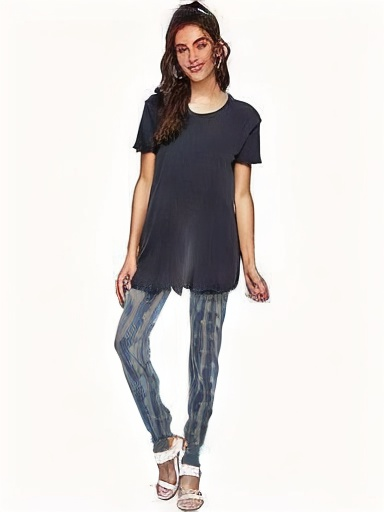

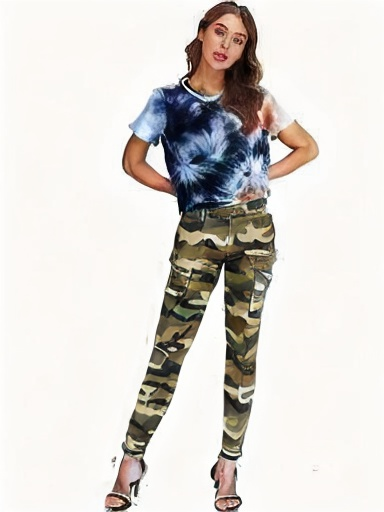

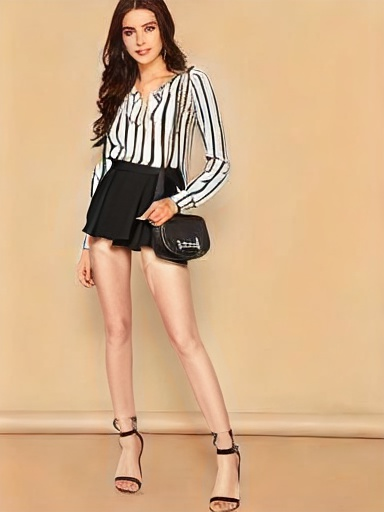

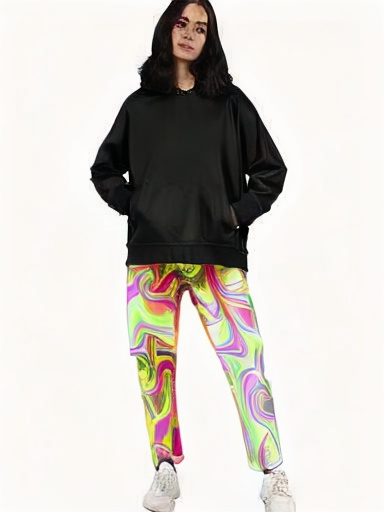

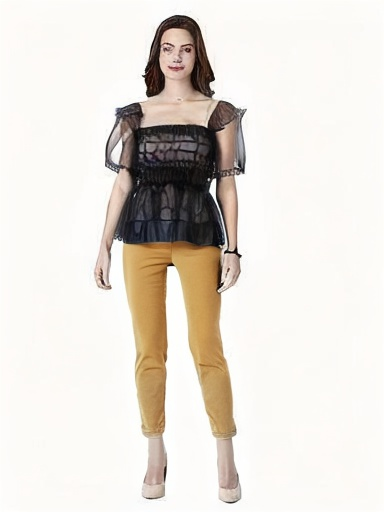

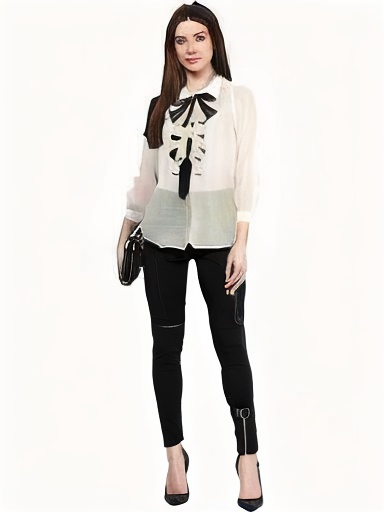

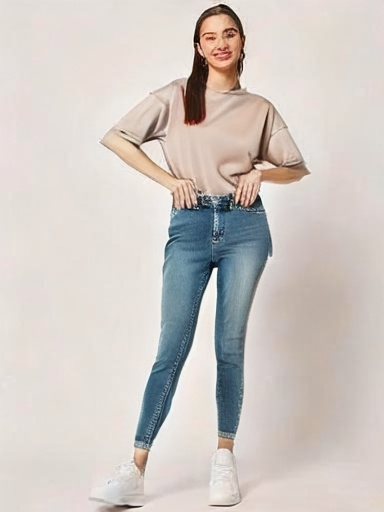

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import glob

pattern = 'results/unpaired/*/*'
for images in glob.glob(pattern):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))

#Results VITON HD

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import glob

pattern = 'results/unpaired/*/*'
for images in glob.glob(pattern):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))

Output hidden; open in https://colab.research.google.com to view.